# Lab 4 - Was T. Rex just a big chicken?
## Computational Proteomics
Material and embedded lab.

Motivation and some exercises are variations on those available in Bioinformatics Algorithms: An Active-Learning Approach by Phillip Compeau & Pavel Pevzner.

In [16]:
debug = True # Set this to False before pushing to be graded
display_available = True
try:
    display('Verifying you can use display')
    from IPython.display import Image
except:
    display_available = False
    display = print
try:
    import pygraphviz
    graphviz_installed = True # Set this to False if you don't have graphviz
except:
    graphviz_installed = False

'Verifying you can use display'

In [28]:
# Just code to help you out here
%matplotlib inline

import networkx as nx
import pandas as pd
import numpy as np
import copy

import matplotlib.pyplot as plt

def draw(A):
    return Image(A.draw(format='png', prog='dot'))

def to_adj(T):
    df = pd.DataFrame(nx.adjacency_matrix(T).todense(),index=T.nodes(),columns=T.nodes())
    for i in range(len(df)):
        for j in range(len(df)):
            if df.iloc[i,j] == 1:
                data = T.get_edge_data(df.index[i],df.columns[j])
                df.iloc[i,j] = data['label']
            else:
                df.iloc[i,j] = ""
    return df

def show(G):
    if graphviz_installed:
        # same layout using matplotlib with no labels
        pos = nx.drawing.nx_agraph.graphviz_layout(G, prog='neato')
        #print(edge_labels)
        # Modify node fillcolor and edge color.
        #D.node_attr.update(color='blue', style='filled', fillcolor='yellow')
        #D.edge_attr.update(color='blue', arrowsize=1)
        A = nx.nx_agraph.to_agraph(G)
        A.graph_attr["rankdir"] = "LR"
        # draw it in the notebook
        if display_available:
            display(draw(A))
        else:
            print(A)
    else:
        if display_available:
            display(to_adj(G))
        else:
            print(to_adj(G))

## Announcements/updates
<img src="https://docs.google.com/drawings/d/e/2PACX-1vS0b5O4cVl4f3HpeqrmmbGbGEbgdfuuv1XJaf2Ui_mNuzVEm0AWhHDpNhaRu7KhhxdtGs2lCGVcJuTs/pub?w=960&h=720" width=700>

## Assignments for week
* Really get to that lab 2
* Get out there and ask me questions about lab 3

## Other announcements
* Extension labs are coming Week 10, so don't cut corners on these strength building labs

## Plans
See headings on slide deck

## Learning Outcomes
* Understand proteomics applications and data
* Apply, analyze, and evaluate proteomics algorithms

## Ice breaker

Head over to slack 448 and answer, "If you could live in one place for a year anywhere in the world, where would it be?". Explain why if you want :)

## Reflection exercise
Take 5 minutes and write or "art" or create in some way based on the following prompt.

Reflect on how you are approaching solving and more importantly understanding the labs. Doodle/consider/write up/etc but produce something. You will NOT be turning this in. It's just for yourself. Think about your process.

After 5 minutes is up, I'll give you an annonymous survey. The survey is not for you to tell me or try to explain your process, but instead just tell me anything you want about the exercise. Just an open share. I will take a look at the break.

# Background

## Paleontology meets computing (and statistics)
Controversy ensues (make sure you note the names in the coming articles)...



* Protein sequencing was very difficult in 1950s but DNA sequencing was impossible
* Today DNA sequencing is essentially trivial while protein sequencing remains difficult
* Dinosaur drama (https://www.wired.com/2009/06/ff-originofspecies/)

<img src="https://images-na.ssl-images-amazon.com/images/I/81ZfeGANs9L._AC_SL1500_.jpg" width=400>

<img src="https://www.researchgate.net/profile/Jeovanis_Gil_Valdes2/publication/321347984/figure/fig2/AS:581671432593414@1515692684716/General-workflow-for-the-mass-spectrometry-based-proteomics-analysis-of-acetylated.png">

Watch the following 10 minute video, and have a member of your team jot down questions and thoughts in the form on this slide.

<a href="https://drive.google.com/file/d/1YFfecODq5pTVWpGtglrHUtlBuW_7dYIU/view?usp=sharing">Bio proteomics</a>

<a href="https://forms.gle/5bT1V12ThA1NPueN6"></a>

## Matching Ideal Spectra
This first section of exercises will allow you to implement algorithms under ideal circumstances where masses are not lost and there is no "noise" mass.

In reality... we have to deal with false and missing masses. One source of this misinformation is that when a mass spectrometer breaks a peptide, small parts of the resulting fragments may be lost, thus lowering their masses (location on the x axis). When breaking REDCA into RE, DCA, RE might lose a water molecule and DCA might lost an ammonia.

**Exercise 1**: Spectrum graph construction

We represent the masses in a spectrum as a sequence Spectrum of integers in increasing order. We define a labeled graph Graph(Spectrum) by forming a node for each element of ``spectrum``, then connecting nodes $s_i$ and $s_j$ by a directed edge labeled by an amino acid $a$ if $s_j−s_i$ is equal to the mass of $a$. We do not distinguish between amino acids having the same integer masses (i.e., the pairs K/Q and I/L). You'll need to add in a zero mass node at the beginning and the sum of all the masses as the last element.

Input: A list of integers ``spectrum``.

Output: A networkx graph that represents the graph described above.

### OK... What?

Let's break down what we know. We know the weights of amino acids

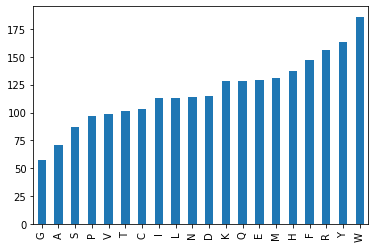

In [18]:
a_mass = {
    "G": 57,
    "A": 71,
    "S": 87,
    "P": 97,
    "V": 99,
    "T": 101,
    "C": 103,
    "I": 113,
    "L": 113,
    "N": 114,
    "D": 115,
    "K": 128,
    "Q": 128,
    "E": 129,
    "M": 131,
    "H": 137,
    "F": 147,
    "R": 156,
    "Y": 163,
    "W": 186
}
import pandas as pd
pd.Series(a_mass).plot.bar();

### We can put that information in a dictionaries that map amino acids to masses and masses to amino acids

In [20]:
import networkx as nx

mass_a = {}
for key in a_mass.keys():
    mass = a_mass[key]
    if mass not in mass_a:
        mass_a[mass] = []
    mass_a[mass].append(key)
    
pd.Series(mass_a) # Just for printing

57        [G]
71        [A]
87        [S]
97        [P]
99        [V]
101       [T]
103       [C]
113    [I, L]
114       [N]
115       [D]
128    [K, Q]
129       [E]
131       [M]
137       [H]
147       [F]
156       [R]
163       [Y]
186       [W]
dtype: object

### What about a real spectrum?
<img src="http://bioinformaticsalgorithms.com/images/Proteomics/dinosaur_spectrum_unannotated.png">

### You could take a look at a spectrum in a very simplified manner

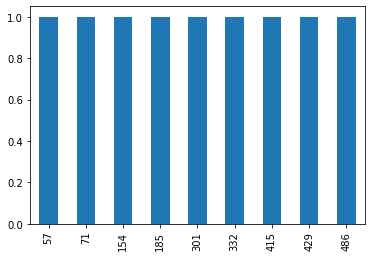

In [29]:
spectrum1 = [57,71,154,185,301,332,415,429,486]
pd.Series(1+0*np.array(spectrum1),index=spectrum1).plot.bar();

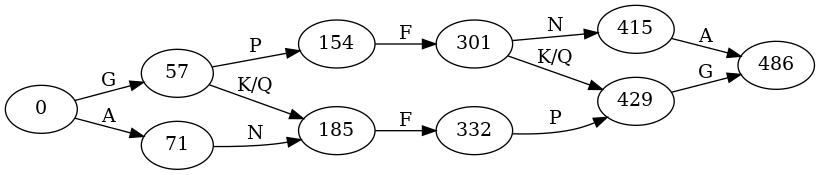

In [22]:
def spectrum_graph_construction(spectrum,mass_a=mass_a):
    spectrum = copy.copy(spectrum)
    spectrum.insert(0,0)
    G = nx.DiGraph()
    for i,s in enumerate(spectrum):
        G.add_node(s)
    # Your solution here
    return G

spectrum1 = [57,71,154,185,301,332,415,429,486]
graph1 = spectrum_graph_construction(spectrum1)

show(graph1)

**Exercise 2**: Ideal spectrum

Input: A ``peptide``

Output: A list that represents the masses of the ideal spectrum

In [26]:
# fragments is for debugging purposes
def ideal_spectrum(peptide,a_mass=a_mass,prefix=True,suffix=True,fragments=[]):
    ideal = [0]
    # Your solution here
    ideal.sort()
    return ideal

peptide1 = "GPG"
spectrum2 = ideal_spectrum(peptide1)
fragments = []
spectrum3 = ideal_spectrum("REDCA",fragments=fragments)

print(f"Spectrum for {peptide1}")
print(spectrum2)
print(f"Fragments for REDCA")
print(fragments)
print(f"Spectrum for REDCA")
print(spectrum3)

Spectrum for GPG
[0, 57, 57, 154, 154, 211]
Fragments for REDCA
['R', 'RE', 'RED', 'REDC', 'REDCA', 'EDCA', 'DCA', 'CA', 'A']
Spectrum for REDCA
[0, 71, 156, 174, 285, 289, 400, 418, 503, 574]


**Exercise 3**: Decoding the ideal spectrum

Input: A ``spectrum``

Output: All matching strings representing the peptide that corresponds to a path from *source* to *sink* in Graph(spectrum) whose ideal spectrum is equal to ``spectrum``.

In [8]:
import numpy as np

def decoding_ideal_spectrum(spectrum,a_mass=a_mass):
    mass_a = {}
    for key in a_mass.keys():
        mass = a_mass[key]
        if mass not in mass_a:
            mass_a[mass] = []
        mass_a[mass].append(key)
    G = spectrum_graph_construction(spectrum,mass_a=mass_a)
    # Your solution here
    matches = []
    return matches

spectrum5 = [57,114,128,215,229,316,330,387,444]
peptides5 = decoding_ideal_spectrum(spectrum5)

print(peptides5)


['GGTTK', 'GGTTQ', 'GGDSK', 'GGDSQ', 'GASDN', 'GATTN', 'NTTAG', 'NDSAG', 'KSDGG', 'QSDGG', 'KTTGG', 'QTTGG']


### Again... What?

Take one of the solutions and take a look at how much it weights.

In [32]:
s=0
for c in 'GGTTQ':
    s += a_mass[c]
s

444

### But does it match the spectrum?

<pre>
spectrum5 = [57,114,128,215,229,316,330,387,444]</pre>

In [34]:
ideal_spectrum("GGTTQ")

[0, 57, 114, 128, 215, 229, 316, 330, 387, 444]

## From Ideal to Real Spectra

**Exercise 4**: Convert a peptide into a binary peptide vector.

Input: A peptide P.

Output: The peptide vector of P as a numpy array.

In [38]:
import numpy as np

def construct_peptide_vector(peptide,a_mass={"X":4,"Z":5},verbose=False):
    total_mass = sum([a_mass[c] for c in peptide])
    vector = np.zeros((total_mass),dtype=int)
    # Your solution here
    return vector

peptide_v1 = construct_peptide_vector("XZZXX")

print(peptide_v1)
display(construct_peptide_vector("XZZXX",verbose=True))

[0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1]


         0
         0
         0
X        1
         0
         0
         0
         0
XZ       1
         0
         0
         0
         0
XZZ      1
         0
         0
         0
XZZX     1
         0
         0
         0
XZZXX    1
dtype: int64

**Exercise 5**: Convert a binary vector into a peptide (do the reverse).

Input: A numpy binary vector ``p``.

Output: A peptide whose binary peptide vector matches ``p``. For masses with more than one amino acid, any choice may be used.

In [10]:
def construct_peptide_from_vector(p,a_mass={"X":4,"Z":5}):
    peptides = []
    # Your solution here
    return peptides

p = np.array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1])
peptides6 = construct_peptide_from_vector(p)

peptides6

['XXZZX', 'XZZXX']

**Exercise 6:** Peptide Sequencing Problem

Input: A spectral vector ``s``.

Output: A peptide with maximum score against ``s``. For masses with more than one amino acid, any choice may be used.

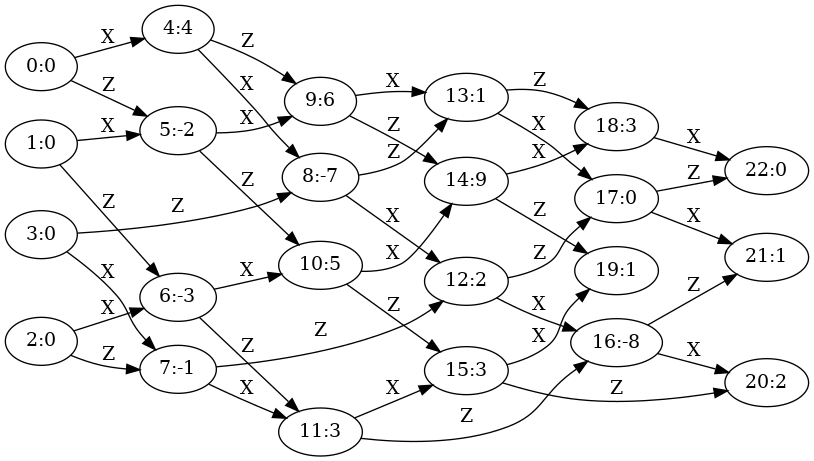

'XZZXX'

In [39]:
def max_peptide(s,a_mass={"X":4,"Z":5},debug=False):
    peptide = ""
    mass_a = {}
    for key in a_mass.keys():
        mass = a_mass[key]
        if mass not in mass_a:
            mass_a[mass] = []
        mass_a[mass].append(key)
    # Your solution here
    return peptide

p2 = [0,0,0,4,-2,-3,-1,-7,6,5,3,2,1,9,3,-8,0,3,1,2,1,0]
peptide7 = max_peptide(p2,debug=debug)

peptide7

### So again... what?

The node labels mean something. The first integer is the mass. There is a transition between 9:6 and 13:1 because X is equal to 4 and so is 13-9. Why do we have a graph? Well. We want to score different options that are paths from this graph. How do we score? Once we have a path we can sum it up using the second integers from the nodes. So a path that went from 9:6 to 13:1 would get a score of ...+6+1+...

In [12]:
# Don't forget to push!